Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Similarity Self-Supervised Learning Hello World

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning and self-supervised learning quick and easy.

Self-supervised learning is an approach to training without using explicit labels. The key insight is that we can train the model to learn augmentation invariance. This produces representations that are generally usefull for down stream tasks. 

Most of these self-supervised models share a common architecture that includes the following:

* Generating at least two augmented views for each example in the batch.

* A **Backbone** model that learns the **Representation** that we will use for the down stream tasks.

* A **Projection** model that is typically a small MLP that includes batch norm.

* A **Predictor** model that is also a small MLP with batch norm. This model is common in more recent architectures and usually has a bottle neck layer.

![byol.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/byol.png)

### Notebook goal

This notebook demonstrates how to use TensorFlow Similarity to pre-train a `ContrastiveModel()` on the cifar10 dataset. 

You are going to learn the main features offered by the `ContrastiveModel()` and will:

1. Create a `tf.data.Dataset` that will generate two augmented views for each example in a batch.

2. Create basic versions of **Backbone**, **Projector**, and **Predictor** networks. These will be used to construct the `ContrastiveModel()`

3. Build a `ContrastiveModel()` using one of the three supported algorithms: `SimCLR`, `SimSiam`, and `Barlow Twins`.

4. Compare the classification performance of training from scratch vs. using the frozen pre-trainined weights.

### Things to try

You can try the following things to improve the model performance:
- Try different self-supervised learning algorithms.
- Use a larger backbone model.
- Use a larger embedding by increasing the size of the projection and predictor layers.
- Try using other augmention functions.

In [2]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
# install TF addons if needed
try:
    import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa

In [6]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

In [7]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [8]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.7.0
TensorFlow Similarity 0.15.0.dev72


## Dataset Preperation

The following section:
* Loads the data from tensorflow datasets.
* Creates the train, val, test, and query/index splits.
* Sets the global vars used for building the different architectures.
* Creates a train and test tf.data.Dataset.
* Visualizes the pairs of augmented views from a single batch.

In [9]:
DATA_PATH = Path("tfsim_contrastive_model")
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

### Load The Raw Data

We are going to load the CIFAR10 dataset. This dataset is often used in the self-supervised papers, enabling us to reproduce the published results. 

In [10]:
((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    batch_size=-1,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [11]:
print(
    tabulate(
        [(cname, cid) for cid, cname in enumerate(ds_info.features['label'].names)],
        headers=["Class Name", "Class ID"],
        numalign="left"
    )
)

Class Name    Class ID
------------  ----------
airplane      0
automobile    1
bird          2
cat           3
deer          4
dog           5
frog          6
horse         7
ship          8
truck         9


### Create Data Splits
The tfds cifar10 dataset comes with a test and train split. 
* **Train**: Data used for the pre-training and evaluation training phases.
* **Test**: Data reserved for the evaluation tests.

However, we are going to partition the train data into the following additional splits:

* **Validation**: Data used for validation metrics during the pre-training phase. 
* **Query and Index**: Data used to compute matching metrics. The query data is used to retrieve the nearest indexed examples.

In particular, the Query and Index split allows us to track the matching classification performance during training. 

<div class="alert alert-block alert-info"> <b>NOTE</b> An increasing match accuracy is a strong indication that the model is learning useful features, however, it does requires that we have labeled data. If a dataset only has a small number of labelled examples, they can be passed as the query and index to help monitor the potential matching classification performance during training.</div> 


In [12]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.extend(idxs[:200])     # 200 query examples per class
    index_idxs.extend(idxs[200:400])  # 200 index examples per class
    val_idxs.extend(idxs[400:500])    # 100 validation examples per class
    train_idxs.extend(idxs[500:])     # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

In [13]:
def create_split(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y)


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

In [16]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
            ["test", x_test.shape, y_test.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples            Labels
-----  ------------------  --------
train  (45000, 32, 32, 3)  (45000,)
val    (1000, 32, 32, 3)   (1000,)
query  (2000, 32, 32, 3)   (2000,)
index  (2000, 32, 32, 3)   (2000,)
test   (10000, 32, 32, 3)  (10000,)


### Global Vars

[TensorFlow Similarity](https://github.com/tensorflow/similarity) currently supports three different self-supervised models.

* (SimCLR)[http://arxiv.org/abs/2002.05709]: Only requires the Backbone and the projector and uses a contrastive cross-entropy loss. This model typically requires large batch sizes.
* (SimSiam)[https://arxiv.org/abs/2011.10566]: Requires the Backbone, projector, and predictor and only compares the cosine distance between augmented views from the same example.
* (Barlow Twins)[https://arxiv.org/abs/2103.03230]: Only requires the Backbone and the projector and uses a loss that compares the feature columns instead of the views.

The `ALGORITHM` var is used throught this notebook to setup the various architectures and the parameters defined below are setup to reproduce the results published in the papers. 

In [17]:
ALGORITHM = "simsiam"  # @param ["barlow", "simsiam", "simclr"]

In [18]:
CIFAR_IMG_SIZE = 32

if ALGORITHM == "simsiam":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "barlow":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 100
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 1000  # we have 10k train steps and we warm up over 10% of that.
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "simclr":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 100
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.

### Building tf.data.Dataset pipelines

Self-supervised networks require two augmented "views" of each example. This can be created using a DataSet and an augmentation function. The DataSet treats each example in the batch as it's own class and then the augment function produces two separate views for each example. 

This means the resulting batch will yield tuples containing the two views, i.e., `Tuple[(BATCH_SIZE, 32, 32, 3), (BATCH_SIZE, 32, 32, 3)]`. 

TensorFlow Similarity provides several random augmentation functions, and here we combining augmenters from the simclr module to replicate the augmentations used in simsiam. This augmenter returns values between [0, 1], but our ResNet backbone model expects the values to be between [0, 255] so we also scale the final output values in the augmentation function.

In [20]:
@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.simclr.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=area_range
    )
    img /= 255.0
    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.simclr.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "simclrv2",
        )

    img = tfsim.augmenters.simclr.random_apply(_jitter_transform, p=0.8, x=img)

    # # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.simclr.to_grayscale(x)

    img = tfsim.augmenters.simclr.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.simclr.random_blur(img, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 1.0)

    return img


@tf.function()
def process(img):
    # SimClrAugmenter returns scaled values between [0,1]
    view1 = simsiam_augmenter(img, blur=False)
    view2 = simsiam_augmenter(img, blur=False)
    # The ResNet model scales internally and expects the inputs to be between [0, 255]
    return (view1 * 255.0, view2 * 255.0)


train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Visualize Batching

The following cell plots the pairs of augmented images next to each other. This can be a useful sanity check as many augmentation functions are setup for the larger ImageNet examples and can be overly aggressive for smaller images found in cifar.

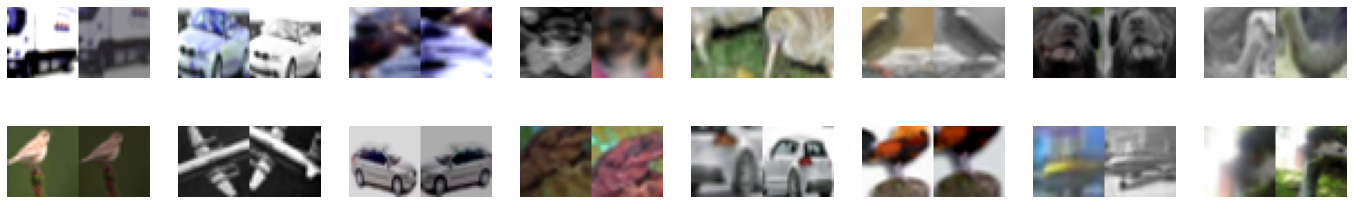

In [21]:
tfsim.visualization.visualize_views(
    views=next(train_ds.as_numpy_iterator()),
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=255.0,
)

## Models

There are various architectures for building self-supervised models which may include some of the following:
* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.

Typically, the projector and predictor networks are only 2 or 3 layers with batch normalization. Several papers claim that the batch normalization is critical to prevent the model from colapsing to a degenerate solution.

Additionally, many papers show a single `encoder` block, but this often contains both the `Backbone` and the `Projector` network.

![contrastive_architecures.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_architecures.png)

### Backbone Model

We are using a version of ResNet18 provided by Tensorflow Similarity in order to reproduce the SimSiam results.

The larger ResNet50 models provided in Tensorflow all use the larger `[(1x1), (3x3), (1x1)]` blocks, but the ResNet18 used in the SimSiam paper requires the smaller `[(3x3), (3x3)]` block.

Additionally, we also provide an implementation of general mean pooling, which allows for variable pooling contrast between global mean and max pooling.

<div class="alert alert-block alert-info"> <b>NOTE</b> This is the model that produces the encoded representation. </div>

In [22]:
def get_backbone(
    img_size, activation="relu", preproc_mode="torch"
):
    input_shape = (img_size, img_size, 3)
    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        augmentation=None,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",      # Can change to use `gem` -> GeneralizedMeanPooling2D
        # gem_p=3.0,        # Increase the contrast between activations in the feature map.
        preproc_mode="torch",
    )
    return backbone


backbone = get_backbone(CIFAR_IMG_SIZE)
backbone.summary()

Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet18 (Functional)       (None, 4, 4, 512)         11182784  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
Total params: 11,182,784
Trainable params: 11,173,056
Non-trainable params: 9,728
_________________________________________________________________


### Projector Model

This MLP is common to all the self-supervised models and is typically a stack of 3 layers of the same size. However, SimSiam only uses 2 layers for the smaller cifar images. Having too much capacity in the models can make it difficult for the loss to stabalize and converge.

Additionally, the SimSiam paper found that disabling the center and scale parameters can lead to a small boost in the final loss.

<div class="alert alert-block alert-info"> <b>NOTE</b> This is the model output that is returned by `ContrastiveModel.predict()` and represents the distance based embedding. </div>

In [23]:
def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
    inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = inputs
    
    for i in range(num_layers - 1):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.LecunUniform(),
            name=f"projector_layer_{i}",
        )(x)
        x = tf.keras.layers.BatchNormalization(
            epsilon=1.001e-5, name=f"batch_normalization_{i}"
        )(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(
            x
        )
    x = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="projector_output",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5,
        center=False,  # Page:5, Paragraph:2 of SimSiam paper
        scale=False,  # Page:5, Paragraph:2 of SimSiam paper
        name=f"batch_normalization_ouput",
    )(x)
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector


projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
projector.summary()

Model: "projector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projector_input (InputLayer  [(None, 512)]            0         
 )                                                               
                                                                 
 projector_layer_0 (Dense)   (None, 2048)              1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 2048)             0         
 on)                                                             
                                                                 
 projector_output (Dense)    (None, 2048)              4194304   
                                                         

### Predictor model

The predictor model is used by BYOL and SimSiam, and is an additional 2 layer MLP containing a bottleneck in the hidden layer.

In [24]:
def get_predictor(input_dim, hidden_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
    x = inputs

    x = tf.keras.layers.Dense(
        hidden_dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_layer_0",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5, name="batch_normalization_0"
    )(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    x = tf.keras.layers.Dense(
        input_dim,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_output",
    )(x)
    o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
    predictor = tf.keras.Model(inputs, o, name="predictor")
    return predictor


predictor = get_predictor(input_dim=DIM, hidden_dim=512)
predictor.summary()

Model: "predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictor_input (InputLayer  [(None, 2048)]           0         
 )                                                               
                                                                 
 predictor_layer_0 (Dense)   (None, 512)               1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 512)              0         
 on)                                                             
                                                                 
 predictor_output (Dense)    (None, 2048)              1050624   
                                                         

## Self-Supervised Algorithms

The following section builds the `ContrastiveModel` based on the `ALGORTHIM` set at the start of the Notebook.

The models are very sensitive to the learning rate decay and weight decay.
* **SimSiam**: Requires using SGD with weight decay from TF Addons. Adding the weight decay as a kernel_regularizer doesn't seem to be able to reproduce the published results in the paper.
* **Barlow Twins**: Requires a warmup period, otherwise the loss explodes.

In [25]:
if ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        predictor=predictor,  # NOTE: simiam requires predictor model.
        algorithm=ALGORITHM,
        name=ALGORITHM,
    )
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=WEIGHT_DECAY,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tfa.optimizers.SGDW(
        learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9
    )
elif ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="barlow",
    )
    lr_decayed_fn = tfsim.schedules.WarmUpCosine(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
        warmup_steps=WARMUP_STEPS,
        warmup_learning_rate=WARMUP_LR,
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm=ALGORITHM,
    )
    optimizer = tf.keras.optimizers.Adam(INIT_LR)
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

### Compile

In [26]:
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

### Callbacks

We track the training using several callbacks. In particular, we use the EvalCallback to monitor the matching classification using the `binary_accuracy`.

In [28]:
log_dir = DATA_PATH / "models" / "logs" / f"{loss.name}_{time.time()}"
chkpt_dir = DATA_PATH / "models" / "checkpoints" / f"{loss.name}_{time.time()}"

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor="loss", patience=50, restore_best_weights=True
# )
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
)
tsc = tfsim.callbacks.EvalCallback(
    tf.cast(x_query, tf.float32),
    y_query,
    tf.cast(x_index, tf.float32),
    y_index,
    metrics=["binary_accuracy"],
    k=1,
    tb_logdir=log_dir,
)
mcp_train = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpt_dir,
    monitor="loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

TensorBoard logging enable in ../../kaggle_ds/google_landmarks/models/logs/simsiam_1640915939.6517866/index


## Train

**Notes**
- SGDW seems to be required to prevent the loss from becoming unstable.
- Per layer kernel_regularization with weight decay doesn't work.
- The kernel initialization seems very critical. Smaller, uniform initalization schemes like Lecunn seem to work best.
- The projector is a more stable output for the KNN match metrics. The predictor ouput is typically worse and higher variance.
- The LR and weight decay schedule seem important. The loss becomes unstable if the updates are too large later in training.
- Too much capacity in the combined model and the training won't converge... same goes for too little capacity.
- Augmentation is critical, but too much augmentation and the model won't converge.

In [ ]:
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[tsc, tbc, mcp_train],
)

binary_accuracy: 0.1995
87/87 [==============================] - 46s 525ms/step - loss: 0.2823 - proj_std: 0.0182 - pred_std: 0.0157 - val_loss: 0.1626 - val_proj_std: 0.0128 - val_pred_std: 0.0109 - binary_accuracy: 0.1995
Epoch 4/800
87/87 [==============================] - 46s 528ms/step - loss: 0.2278 - proj_std: 0.0177 - pred_std: 0.0162 - val_loss: 0.1882 - val_proj_std: 0.0150 - val_pred_std: 0.0133 - binary_accuracy: 0.1880
Epoch 5/800
87/87 [==============================] - 46s 524ms/step - loss: 0.2011 - proj_std: 0.0176 - pred_std: 0.0162 - val_loss: 0.0971 - val_proj_std: 0.0119 - val_pred_std: 0.0102 - binary_accuracy: 0.2045
Epoch 6/800
87/87 [==============================] - 46s 528ms/step - loss: 0.1912 - proj_std: 0.0178 - pred_std: 0.0165 - val_loss: 0.1077 - val_proj_std: 0.0131 - val_pred_std: 0.0116 - binary_accuracy: 0.1870
Epoch 7/800
87/87 [==============================] - 46s 526ms/step - loss: 0.1887 - proj_std: 0.0179 - pred_std: 0.0166 - val_loss: 0.0771 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



87/87 [==============================] - 45s 519ms/step - loss: 0.1754 - proj_std: 0.0189 - pred_std: 0.0185 - val_loss: 0.2135 - val_proj_std: 0.0175 - val_pred_std: 0.0172 - binary_accuracy: 0.3485
Epoch 45/800
87/87 [==============================] - 45s 519ms/step - loss: 0.1675 - proj_std: 0.0191 - pred_std: 0.0187 - val_loss: 0.1199 - val_proj_std: 0.0125 - val_pred_std: 0.0113 - binary_accuracy: 0.3465
Epoch 46/800
87/87 [==============================] - 46s 527ms/step - loss: 0.1608 - proj_std: 0.0191 - pred_std: 0.0187 - val_loss: 0.1003 - val_proj_std: 0.0114 - val_pred_std: 0.0105 - binary_accuracy: 0.3625
Epoch 47/800
87/87 [==============================] - 46s 527ms/step - loss: 0.1576 - proj_std: 0.0191 - pred_std: 0.0188 - val_loss: 0.0942 - val_proj_std: 0.0123 - val_pred_std: 0.0114 - binary_accuracy: 0.3705
Epoch 48/800
87/87 [==============================] - 45s 518ms/step - loss: 0.1578 - proj_std: 0.0193 - pred_std: 0.0190 - val_loss: 0.1079 - val_proj_std: 0.01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



binary_accuracy: 0.6555
87/87 [==============================] - 46s 528ms/step - loss: 0.1221 - proj_std: 0.0217 - pred_std: 0.0216 - val_loss: 0.1476 - val_proj_std: 0.0207 - val_pred_std: 0.0206 - binary_accuracy: 0.6555
Epoch 225/800
87/87 [==============================] - 45s 519ms/step - loss: 0.1250 - proj_std: 0.0217 - pred_std: 0.0216 - val_loss: 0.1451 - val_proj_std: 0.0212 - val_pred_std: 0.0212 - binary_accuracy: 0.6885
Epoch 230/800
87/87 [==============================] - 45s 519ms/step - loss: 0.1258 - proj_std: 0.0217 - pred_std: 0.0216 - val_loss: 0.1430 - val_proj_std: 0.0213 - val_pred_std: 0.0212 - binary_accuracy: 0.6805
Epoch 231/800
87/87 [==============================] - 45s 519ms/step - loss: 0.1273 - proj_std: 0.0217 - pred_std: 0.0217 - val_loss: 0.1403 - val_proj_std: 0.0212 - val_pred_std: 0.0212 - binary_accuracy: 0.6620
Epoch 232/800
87/87 [==============================] - 45s 519ms/step - loss: 0.1266 - proj_std: 0.0217 - pred_std: 0.0217 - val_loss:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



87/87 [==============================] - 45s 519ms/step - loss: 0.1151 - proj_std: 0.0215 - pred_std: 0.0215 - val_loss: 0.1312 - val_proj_std: 0.0211 - val_pred_std: 0.0211 - binary_accuracy: 0.7355
Epoch 387/800
87/87 [==============================] - 45s 518ms/step - loss: 0.1142 - proj_std: 0.0215 - pred_std: 0.0214 - val_loss: 0.1267 - val_proj_std: 0.0210 - val_pred_std: 0.0209 - binary_accuracy: 0.7195
Epoch 391/800
87/87 [==============================] - 45s 521ms/step - loss: 0.1101 - proj_std: 0.0214 - pred_std: 0.0213 - val_loss: 0.1230 - val_proj_std: 0.0211 - val_pred_std: 0.0210 - binary_accuracy: 0.7415
Epoch 392/800
87/87 [==============================] - 45s 518ms/step - loss: 0.1132 - proj_std: 0.0215 - pred_std: 0.0214 - val_loss: 0.1492 - val_proj_std: 0.0207 - val_pred_std: 0.0207 - binary_accuracy: 0.7165
Epoch 393/800
87/87 [==============================] - 46s 528ms/step - loss: 0.1073 - proj_std: 0.0214 - pred_std: 0.0213 - val_loss: 0.1312 - val_proj_std: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



87/87 [==============================] - 46s 528ms/step - loss: 0.0782 - proj_std: 0.0211 - pred_std: 0.0211 - val_loss: 0.1261 - val_proj_std: 0.0209 - val_pred_std: 0.0209 - binary_accuracy: 0.8220
Epoch 629/800
87/87 [==============================] - ETA: 0s - loss: 0.0788 - proj_std: 0.0211 - pred_std: 0.0211

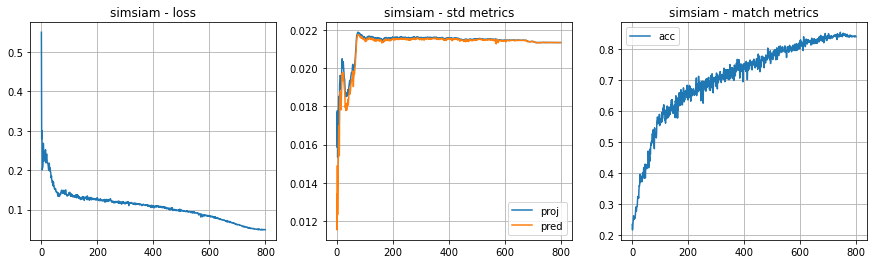

In [42]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history.history["loss"])
plt.grid()
plt.title(f"{loss.name} - loss")

plt.subplot(1,3,2)
plt.plot(history.history["proj_std"], label="proj")
plt.plot(history.history["pred_std"], label="pred")
plt.grid()
plt.title(f"{loss.name} - std metrics")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history["binary_accuracy"], label="acc")
plt.grid()
plt.title(f"{loss.name} - match metrics")
plt.legend()

plt.show()

## Save and Reload

The `ContrastiveModel` implements a custom save function that performs the following:
* Saves each of the sub model, including the predictor if one exists.
* A JSON file containing the serialized Loss, Metrics, and Optimizer.
* The Optimizer weights as a npy file.

We also provide a custom `load_model()` function that will restore the `ContrastiveModel` and supports continued training. However, the initital_epoch value may need to be set if the model optimizers use a learning rate schedule.

In [ ]:
#contrastive_model.load_weights(DATA_PATH / 'models' / 'checkpoints' / 'simsiam_80acc')

In [28]:
contrastive_model.save(DATA_PATH / 'models' / f'trained_model')

[Saving backbone model]
|-path:../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/backbone


2021-12-29 19:12:57.757048: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/backbone/assets


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/backbone/assets
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Index not saved as save_index=False
[Saving projector model]
|-path:../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/projector


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/projector/assets


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/projector/assets


[Saving predictor model]
|-path:../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/predictor


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/predictor/assets


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam__85acc/predictor/assets
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [27]:
del contrastive_model

In [31]:
contrastive_model = tfsim.models.contrastive_model.load_model(DATA_PATH / 'models' / f'trained_model')

## Evaluation

This final section trains two different classifiers.

1. Uses the same backbone model but does not freeze the weights.

2. Uses the frozen pre-trained backbonefrom the ContrastiveModel.

The train data is partitioned into eval_train and eval_val splits. The models are trained for 10 epochs and the classification accuarcy is evaluated on the holdout test split.

In [32]:
TEST_EPOCHS = 10
TEST_STEPS_PER_EPOCH = int(len(x_train) // BATCH_SIZE)

In [33]:
@tf.function
def eval_augmenter(img):
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.simclr.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=(0.2, 1.0)
    )
    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 255.0)

    return img

In [34]:
eval_train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.keras.utils.to_categorical(y_train, 10))
)
eval_train_ds = eval_train_ds.repeat()
eval_train_ds = eval_train_ds.shuffle(1024)
eval_train_ds = eval_train_ds.map(lambda x, y: (eval_augmenter(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.batch(BATCH_SIZE)
eval_train_ds = eval_train_ds.prefetch(tf.data.AUTOTUNE)

eval_val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val, tf.keras.utils.to_categorical(y_val, 10))
)
eval_val_ds = eval_val_ds.repeat()
eval_val_ds = eval_val_ds.shuffle(1024)
eval_val_ds = eval_val_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_val_ds = eval_val_ds.batch(BATCH_SIZE)
eval_val_ds = eval_val_ds.prefetch(tf.data.AUTOTUNE)

eval_test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, tf.keras.utils.to_categorical(y_test, 10))
)
eval_test_ds = eval_test_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_test_ds = eval_test_ds.batch(BATCH_SIZE)
eval_test_ds = eval_test_ds.prefetch(tf.data.AUTOTUNE)

In [35]:
def get_eval_model(img_size, backbone, total_steps, trainable=True, lr=1.8):
    backbone.trainable = trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs, training=trainable)
    o = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs, o)
    cosine_decayed_lr = tf.keras.experimental.CosineDecay(
        initial_learning_rate=lr, decay_steps=total_steps
    )
    opt = tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
    return model

### No Pretrain

In [36]:
no_pt_eval_model = get_eval_model(
    img_size=CIFAR_IMG_SIZE,
    backbone=get_backbone(CIFAR_IMG_SIZE, DIM),
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=True,
    lr=1e-3,
)
no_pt_history = no_pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
87/87 [==============================] - 23s 244ms/step - loss: 2.0407 - acc: 0.2540 - val_loss: 1.7584 - val_acc: 0.3763
Epoch 2/10
87/87 [==============================] - 21s 240ms/step - loss: 1.7529 - acc: 0.3550 - val_loss: 1.6014 - val_acc: 0.4241
Epoch 3/10
87/87 [==============================] - 21s 240ms/step - loss: 1.6615 - acc: 0.3934 - val_loss: 1.5129 - val_acc: 0.4548
Epoch 4/10
87/87 [==============================] - 21s 240ms/step - loss: 1.6131 - acc: 0.4116 - val_loss: 1.4662 - val_acc: 0.4626
Epoch 5/10
87/87 [==============================] - 21s 240ms/step - loss: 1.5742 - acc: 0.4282 - val_loss: 1.4234 - val_acc: 0.4893
Epoch 6/10
87/87 [==============================] - 21s 240ms/step - loss: 1.5409 - acc: 0.4432 - val_loss: 1.4026 - val_acc: 0.4928
Epoch 7/10
87/87 [==============================] - 21s 240ms/step - loss: 1.5200 - acc: 0.4509 - val_loss: 1.3828 - val_acc: 0.4953
Epoch 8/10
87/87 [==============================] - 21s 240ms/step - 

### Pretrained

In [37]:
pt_eval_model = get_eval_model(
    CIFAR_IMG_SIZE,
    contrastive_model.backbone,
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=False,
    lr=30.0,
)
pt_eval_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eval_input (InputLayer)     [(None, 32, 32, 3)]       0         
                                                                 
 resnet18sim (SimilarityMode  (None, 512)              11182784  
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 11,187,914
Trainable params: 5,130
Non-trainable params: 11,182,784
_________________________________________________________________


In [38]:
pt_history = pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
87/87 [==============================] - 7s 75ms/step - loss: 32.9980 - acc: 0.1108 - val_loss: 35.1883 - val_acc: 0.1084
Epoch 2/10
87/87 [==============================] - 6s 72ms/step - loss: 28.8937 - acc: 0.1354 - val_loss: 10.3902 - val_acc: 0.1705
Epoch 3/10
87/87 [==============================] - 6s 71ms/step - loss: 19.4291 - acc: 0.2023 - val_loss: 12.4108 - val_acc: 0.2138
Epoch 4/10
87/87 [==============================] - 6s 72ms/step - loss: 8.9099 - acc: 0.3288 - val_loss: 0.9773 - val_acc: 0.7566
Epoch 5/10
87/87 [==============================] - 6s 71ms/step - loss: 0.5279 - acc: 0.8455 - val_loss: 0.3716 - val_acc: 0.8806
Epoch 6/10
87/87 [==============================] - 6s 71ms/step - loss: 0.4188 - acc: 0.8665 - val_loss: 0.3527 - val_acc: 0.8900
Epoch 7/10
87/87 [==============================] - 6s 72ms/step - loss: 0.3996 - acc: 0.8717 - val_loss: 0.3544 - val_acc: 0.8848
Epoch 8/10
87/87 [==============================] - 6s 71ms/step - loss: 0.39

### Comparison

In [39]:
# SimSiam
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 2s 75ms/step - loss: 1.3831 - acc: 0.5029
no pretrain [1.3830921649932861, 0.5029000043869019]
20/20 [==============================] - 1s 57ms/step - loss: 0.3878 - acc: 0.8716
pretrained [0.38776251673698425, 0.8715999722480774]


In [ ]:
# SimCLR
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

In [ ]:
# Barlow Pre-train Cifar 10
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))